# There is no plan bee without them 🐝

## Abstract
Pollinators around the world play a central role in our agriculture with an estimated economic benefit of €235bn per year. Up to 75% of our crops are dependent on pollination and honeybees account for most of it. Yet, in Europe and the USA the bee population has been declining at an alarming rate during the last decades. As by-hand pollination is not an alternative, it is impossible to imagine a world without them. [1]

With this project, we first aim at giving insights about the state of bee health and honey produced and traded using the [FAO datasets](http://www.fao.org/faostat/en/#data). Secondly, we focus on the USA using results from [US Departement of Agriculture](https://quickstats.nass.usda.gov/) in order to identify and present the main factors of bee decline. Finally, we propose a case study about almonds in California to show the consequences of a lack of bees.

[[1](http://sos-bees.org/wp-content/uploads/2014/04/BeesInDecline.pdf)] *Bees in Decline*, Greenpeace, 2013



In [186]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rc('font', **{'size': 12}) # Text more readable

## 1. How do the continents compare in terms of bee decline from 1961 to these days?

Our first goal is to plot the evolution of the number of beehives per continent. For this purpose, we use the dataset from FAOSTAT, that lists the number of beehives per country from 1961.

In [156]:
beehives_raw = pd.read_csv('data/FAOSTAT_Live_Stock.csv')
beehives_raw.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QA,Live Animals,3,Albania,5114,Stocks,1181,Beehives,1961,1961,No,95100.0,NaN,Official data
1,QA,Live Animals,3,Albania,5114,Stocks,1181,Beehives,1962,1962,No,92800.0,NaN,Official data
2,QA,Live Animals,3,Albania,5114,Stocks,1181,Beehives,1963,1963,No,83500.0,NaN,Official data
3,QA,Live Animals,3,Albania,5114,Stocks,1181,Beehives,1964,1964,No,96500.0,NaN,Official data
4,QA,Live Animals,3,Albania,5114,Stocks,1181,Beehives,1965,1965,No,109800.0,NaN,Official data


Let's only select the columns that interest us, i.e. everythin apart from the country, the year and the number of beehives.

In [157]:
beehives_raw = beehives_raw[['Area', 'Year', 'Value']]
beehives_raw.head()

,Area,Year,Value
0,Albania,1961,95100.0
1,Albania,1962,92800.0
2,Albania,1963,83500.0
3,Albania,1964,96500.0
4,Albania,1965,109800.0


Then, let's import a small dataset that lists all the countries in the world to their respective continents. The csv file was [found here](https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv).

In [158]:
countries = pd.read_csv('data/countries.csv')
# We only want the name of the country and its continent
countries = countries[['name', 'region']]
countries = countries.set_index('name')
print('Are the countries in the dataset unique? -> %s' % countries.index.is_unique)
countries.head()

Are the countries in the dataset unique? -> True


,region
name,
Afghanistan,Asia
Åland Islands,Europe
Albania,Europe
Algeria,Africa
American Samoa,Oceania


The `countries` dataset does not have data from certain countries present in the FAOSTAT dataset. These countries have either ceased to exist (USSR, Yugoslavia, ...), or were defined differently (China, mainland, ...).

In [159]:
countries.loc['Belgium-Luxembourg'] = 'Europe'
countries.loc['China, mainland'] = 'Asia'
countries.loc['China, Taiwan Province of'] = 'Asia'
countries.loc['Czechoslovakia'] = 'Europe'
countries.loc['Ethiopia PDR'] = 'Africa'
countries.loc['Palestine'] = 'Asia'
countries.loc['Republic of Korea'] = 'Asia'
countries.loc['Republic of Moldova'] = 'Europe'
countries.loc['Serbia and Montenegro'] = 'Europe'
countries.loc['Sudan (former)'] = 'Africa'
countries.loc['United Kingdom'] = 'Europe'
countries.loc['United Republic of Tanzania'] = 'Africa'
countries.loc['USSR'] = 'Europe'
countries.loc['Wallis and Futuna Islands'] = 'Oceania'
countries.loc['Yugoslav SFR'] = 'Europe'

countries['region'].value_counts()

Africa      63
Europe      58
Americas    57
Asia        55
Oceania     30
Name: region, dtype: int64

We indeed verify that all 5 continents are present.

Then, we add the continent as a column in our beehive dataset.

In [160]:
beehives_raw['Continent'] = beehives_raw.apply(lambda row: countries.loc[row['Area']], axis=1)
beehives_raw.head()

,Area,Year,Value,Continent
0,Albania,1961,95100.0,Europe
1,Albania,1962,92800.0,Europe
2,Albania,1963,83500.0,Europe
3,Albania,1964,96500.0,Europe
4,Albania,1965,109800.0,Europe


We can now aggregate the values together for each continent.

In [170]:
beehives = beehives_raw.drop('Area', 1)
beehives = beehives.pivot_table(index=['Year'], columns=['Continent'], aggfunc=np.sum)
beehives.columns.names = ['Number of beehives', 'Continent']
beehives.head()

Number of beehives      Value                                              
Continent              Africa    Americas        Asia      Europe   Oceania
Year                                                                       
1961                6845050.0  10019254.0  14060894.0  21097615.0  506660.0
1962                6986195.0  10038371.0  14361851.0  21182265.0  530345.0
1963                7291050.0   9388825.0  14559696.0  21758651.0  491061.0
1964                7365275.0   9261154.0  14963317.0  21159899.0  533889.0
1965                7822375.0   8221129.0  16588637.0  20966688.0  526280.0

Let's plot the absolute values to see what is exactly going on.

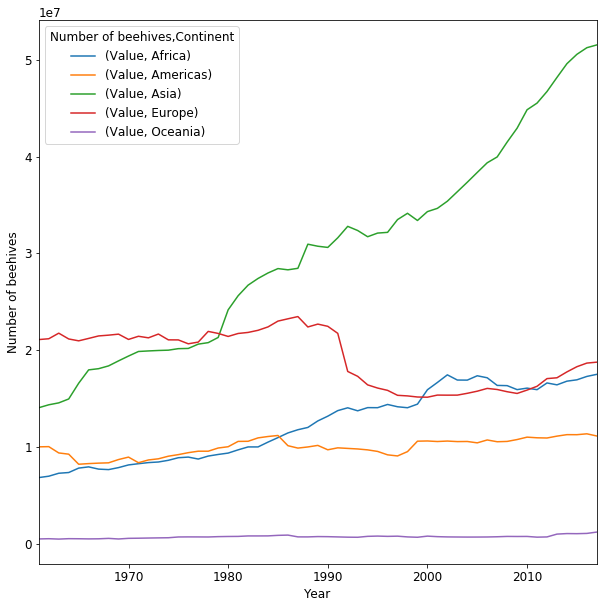

In [187]:
def plot_beehives(df):
    ax = df.plot(kind='line', figsize=(10,10))
    ax.set_ylabel('Number of beehives')
    return ax
    
plot_beehives(beehives);

We can observe the following:

- Asia sees the biggest growth on Earth, surpassing Europe in the 80s.
- Europe saw a sharp decline in the 90s, and recovers slowly since the 2010s.
- Afica does not see any real change since the beggining of the 2000s
- Americas seem to not really evolve in numbers since the beginning.
- It's difficult to tell for Oceania.

That's all well and good, but the most interesting statistic would be to see the derivate of these values. Let's modify our pivot table.

In [193]:
beehives_derivative = beehives.diff() / beehives
# This obviously creates a NaN value for the first year, let's replace it by 0
beehives_derivative = beehives_derivative.fillna(0)

Now, let's compute the values for Europe.

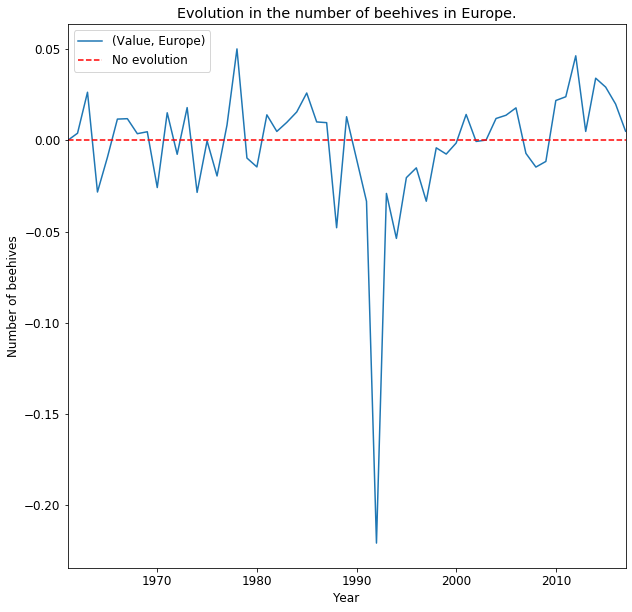

In [194]:
beehives_evol_eur = beehives_derivative[('Value','Europe')]
ax = plot_beehives(beehives_evol_eur)
ax.axhline(y=0.0, color='red', linestyle='--', label='No evolution')
ax.set_title('Evolution in the number of beehives in Europe.')
plt.legend();

In [212]:
decrease = abs(beehives_evol_eur.min()*100)
msg = 'Europe saw their worst year in total beehives numbers in %d, where it lost %.1f%% of their count.'
print(msg % (beehives_evol_eur.idxmin(), decrease))

Europe saw their worst year in total beehives numbers in 1992, where it lost 22.1% of their count.


We can see a very sharp decline in 1992. Let's investigate on where it came from, by looking at the individual countries in Europe.

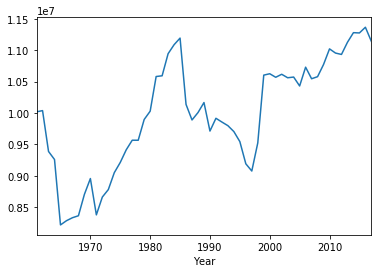

In [135]:
beehives[('Value', 'Americas')].plot(kind='line')

## 2. How do changes in honey production relate to number of beehives in Europe and the USA?

Robin

## 3. What are the consequences of bee decline on the patterns of honey import/export around the world?

Eric

## 4. What is the relation between US cases of Colony Collapse Disorder and the main factors of CCD?

Arthur

## 5. California accounts for 80% of the world almond production, what is the impact of bees on this industry in the 21st century?

Tim & Arthur